In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với Close
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/JPYUSDX.csv')
df = df.dropna()
df=df.reset_index()['Close']


In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 5s 74ms/step - loss: 0.1335 - val_loss: 0.0124
Epoch 2/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0124 - val_loss: 0.0019
Epoch 3/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 4/100
17/17 [==============================] - 1s 43ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 5/100
17/17 [==============================] - 1s 44ms/step - loss: 8.2989e-04 - val_loss: 0.0047
Epoch 6/100
17/17 [==============================] - 1s 56ms/step - loss: 6.2078e-04 - val_loss: 0.0054
Epoch 7/100
17/17 [==============================] - 1s 53ms/step - loss: 5.6744e-04 - val_loss: 0.0054
Epoch 8/100
17/17 [==============================] - 1s 46ms/step - loss: 5.6398e-04 - val_loss: 0.0050
Epoch 9/100
17/17 [==============================] - 1s 50ms/step - loss: 5.3052e-04 - val_loss: 0.0046
Epoch 10/100
17/17 [==============================] - 1s 49ms/step - loss: 5.385

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 18ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# Chia train test lại
train_data1 = df[:train_size]
test_data1 = df[train_size:train_size+test_size]
val_data1 = df[train_size+test_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [13]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 0.00029140255896779475
Testing RMSE: 0.000645775159478429
Validation MAPE: 3.148900104984144
Testing MAPE: 7.43989885763953
Validation MAE: 0.00023659863861104428
Testing MAE: 0.0005524884978348837


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[43:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.34805195 0.32402597 0.33084416 0.35032468 0.33928571 0.33831169
 0.3262987  0.33344156 0.36233766 0.35974026 0.2974026  0.28603896
 0.31558442 0.30909091 0.30649351 0.30616883 0.29123377 0.27922078
 0.26266234 0.25974026 0.25551948 0.25487013 0.24350649 0.24415584
 0.24967532 0.21850649 0.21980519 0.21915584 0.22175325 0.21298701
 0.22792208 0.22532468 0.20097403 0.2038961  0.21850649 0.24350649
 0.27694805 0.2538961  0.28051948 0.2724026  0.29220779 0.30909091
 0.29123377 0.31298701 0.31883117 0.31948052 0.31201299 0.31558442
 0.28701299 0.27532468 0.27272727 0.29220779 0.30714286 0.31753247
 0.3038961  0.29577922 0.27045455 0.26818182 0.2775974  0.28863636
 0.26136364 0.25324675 0.26006494 0.24837662 0.26103896 0.26168831
 0.25941558 0.26623377 0.27077922 0.26461039 0.21850649 0.19902597
 0.21720779 0.2512987  0.25779221 0.23961039 0.24155844 0.23798701
 0.25941558 0.25194805 0.22857143 0.22467532 0.21785714 0.1974026
 0.18019481 0.1961039  0.17922078 0.18051948 0.1691

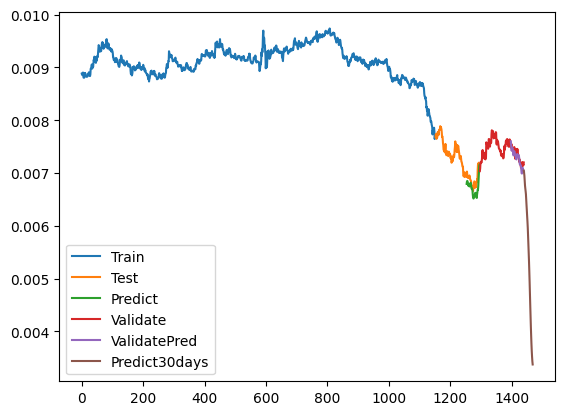

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()